In [29]:
import pandas as pd
import os
import plotly_express as px
from collections import  Counter
import datetime as dt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from api_funcs import connectAPI
%matplotlib inline

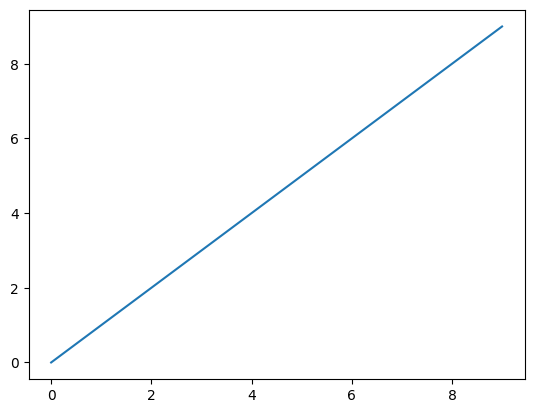

In [1]:
import matplotlib.pyplot as plt
plt.plot(range(0,10),range(0,10))

### Load the dataframes from the APIs
1. Read configurations from config.ini
2. Use connectAPI class to gather data


In [30]:
# Connect to the Rick and Morty API and build dataframes
df_rm_character = connectAPI("RICKMORTYAPI",'character').get_results_df()
df_rm_episode = connectAPI("RICKMORTYAPI",'episode').get_results_df()

connected to https://rickandmortyapi.com/api/character
connected to https://rickandmortyapi.com/api/episode


In [31]:
# Connect to the Star Wars API and build dataframes
df_sw_films = connectAPI('SWAPI', 'films').get_results_df()
df_sw_people = connectAPI("SWAPI", 'people').get_results_df()

connected to https://swapi.dev/api/films
connected to https://swapi.dev/api/people


In [32]:
# Connect to the movie db API and build dataframe
if not os.path.exists("./df_tmdb_people.csv"):
    df_tmdb_people = connectAPI("TMDBAPI",'person').get_results_df()
    df_tmdb_people.to_csv("df_tmdb_people.csv")
else:
    df_tmdb_people = pd.read_csv("df_tmdb_people.csv")

In [33]:
# clean up 
df_sw_people['gender'][df_sw_people['gender']=='none'] = 'Not Specified'
df_sw_people['gender'][df_sw_people['gender']=='n/a'] = 'Genderless'
df_rm_character['gender'][df_rm_character['gender']=='Unknown'] = 'Not Specified'

df_rm_character['gender'] = df_rm_character["gender"].str.capitalize()
df_sw_people['gender'] = df_sw_people["gender"].str.capitalize()

/var/folders/b_/g3c_7hwd70j9k5t4lqfhswnh0000gn/T/ipykernel_68885/207405348.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Total gender distributions: 


In [34]:
sw = pd.DataFrame(df_sw_people["gender"].value_counts()).reset_index()
rm = pd.DataFrame(df_rm_character["gender"].value_counts()).reset_index()
md = pd.DataFrame(df_tmdb_people["gender"].value_counts())
df_temp = df_tmdb_people.groupby("gender").sum()
md["Total Credits"] = df_temp["n_credits"]
md = md.reset_index()

In [35]:
if not os.path.exists("images"):
    os.mkdir("images")

In [36]:
titles=["Character Genders in Star Wars", 
        "Character Genders in Rick & Morty",
        "Character Genders in the Movie Database"]
dfs = [sw, rm, md]
for i in range(len(dfs)):
    fig = px.pie(dfs[i], values="gender", names="index", 
                title=titles[i], 
                width=600, height=400)

    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=-0.5
    ))
    #fig.write_image("./images/pie"+str(i)+".png")
    fig.show()

In [37]:
fig = px.pie(md, values="Total Credits", names="index", 
            title= "Character Movie Credits based on Genders in the Movie DB",
            width=600, height=400)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=-0.5
))

fig.show()

## Time evolution in gender distributions

1. Get the movie/episode specific gender distributions
2. Plot male and female values per episode/film

In [38]:
# Get gender from the character url
def get_gender(df, url_col, char_url):
    mask = df[url_col] == char_url
    return df[mask]['gender'].values[0]

# Adds total male and female counts to the film/episode tables
def add_counts(df_item, df_char):
    df_item['Male'] = 0
    df_item['Female'] = 0
    for row in df_item.iterrows():
        char_list = row[1].loc['characters']
        lst_gender = []
        for char in char_list:
            lst_gender.append(get_gender(df_char, 'url', char))
        c = Counter(lst_gender)
        df_item.loc[row[0], 'Male'] = c['Male']
        df_item.loc[row[0], 'Female'] = c['Female']
    return df_item

def plot_barchart(df_new, x_var, y_var, bar_title, x_tick_label=None):
    fig = px.bar(df_new, x=x_var, y=y_var, 
                labels={ "value":"Number of characters",
                        "variable":"Gender",
                        "Gender":y_var},
                )
    if x_tick_label:
        ticktext_value = [i[0]+', '+i[1] for i in zip( list(map(str,df_new[x_var])), df_new[x_tick_label])]
    else:
        ticktext_value = list(map(str,df_new[x_var]))
    fig.update_layout(
        height=500,
        width =800,
        title_text = bar_title,
        xaxis = dict(
            tickmode = 'array',
            tickvals = df_new[x_var],
            ticktext = ticktext_value
        )
    )

    fig.show()

In [39]:
# clean up the release date
df_sw_films['Year'] = pd.to_datetime(df_sw_films['release_date']).dt.strftime('%Y')


In [40]:
df_sw_films = add_counts(df_sw_films, df_sw_people)

plot_barchart(df_sw_films, x_var = "Year", y_var=["Male", "Female"],
              bar_title = "Star Wars characters by gender in movies", x_tick_label = 'title' )

In [41]:
# add male and female counts
df_rm_episode = add_counts(df_rm_episode, df_rm_character)


In [42]:
# add reformated date column as datetime data type
df_rm_episode['Date'] = pd.to_datetime(df_rm_episode['air_date'])#.dt.strftime('%d-%m-%Y')

In [43]:
df_rm_yearly = df_rm_episode.groupby(df_rm_episode['Date'].dt.year)[['Male', "Female"]].sum().reset_index()
df_rm_yearly.Date = df_rm_yearly.Date.astype('str')

In [44]:
plot_barchart(df_rm_yearly,"Date",["Male", "Female"], bar_title = "Rick & Morty characters by gender per episode")

In [45]:
# comparison of percentages as a function of time for rm and sw gender distributions
df_rm_yearly["Female Percentage"] = 100*df_rm_yearly["Female"]/(df_rm_yearly["Female"]+df_rm_yearly["Male"])
df_sw_films["Female Percentage"] = 100*df_sw_films["Female"]/(df_sw_films["Female"]+df_sw_films["Male"])

In [46]:
df_sw_films["Year"] = df_sw_films["Year"].astype("int")
df_rm_yearly["Year"] = df_rm_yearly["Date"].astype("int")

In [47]:
merged_df = df_sw_films.merge(df_rm_yearly, on="Year", how="outer")
merged_df = merged_df.rename(columns= {"Female Percentage_x":"Star Wars","Female Percentage_y":"Rick and Morty"})

In [48]:
fig = px.line(merged_df, x="Year", y=["Star Wars","Rick and Morty"], markers='o',
                               labels={
                     "value": "% Female",
                     "variable":"",
                 },)
fig.update_layout(title_text="Time evolution of percentage of total female characters")
fig.show()
#fig.update_layout(x)